In [1]:
import importlib

In [2]:
task = importlib.import_module('pose')

In [3]:
configs = task.__config__

In [4]:
configs

{'data_provider': 'dp',
 'network': 'posenet.PoseNet',
 'inference': {'nstack': 8,
  'inp_dim': 256,
  'oup_dim': 16,
  'num_parts': 16,
  'increase': 0,
  'keys': ['imgs'],
  'num_eval': 2958,
  'train_num_eval': 300},
 'train': {'batchsize': 8,
  'input_res': 256,
  'output_res': 64,
  'train_iters': 1000,
  'valid_iters': 10,
  'learning_rate': 0.001,
  'max_num_people': 1,
  'loss': [['combined_hm_loss', 1]],
  'decay_iters': 100000,
  'decay_lr': 0.0002,
  'num_workers': 2,
  'use_data_loader': True}}

In [5]:
configs['data_provider'] = importlib.import_module(configs['data_provider'])

In [6]:
configs

{'data_provider': <module 'dp' from '/home/lab/MPII_COCO/MPII_GITHUB/dp.py'>,
 'network': 'posenet.PoseNet',
 'inference': {'nstack': 8,
  'inp_dim': 256,
  'oup_dim': 16,
  'num_parts': 16,
  'increase': 0,
  'keys': ['imgs'],
  'num_eval': 2958,
  'train_num_eval': 300},
 'train': {'batchsize': 8,
  'input_res': 256,
  'output_res': 64,
  'train_iters': 1000,
  'valid_iters': 10,
  'learning_rate': 0.001,
  'max_num_people': 1,
  'loss': [['combined_hm_loss', 1]],
  'decay_iters': 100000,
  'decay_lr': 0.0002,
  'num_workers': 2,
  'use_data_loader': True}}

In [7]:
import torch.nn as nn
import torch
class Trainer(nn.Module):
    """
    The wrapper module that will behave differetly for training or testing
    inference_keys specify the inputs for inference
    """
    def __init__(self, model, inference_keys, calc_loss=None):
        super(Trainer, self).__init__()
        self.model = model
        self.keys = inference_keys
        self.calc_loss = calc_loss

    def forward(self, imgs, **inputs):
        inps = {}
        labels = {}

        for i in inputs:
            if i in self.keys:
                inps[i] = inputs[i]
            else:
                labels[i] = inputs[i]

        if not self.training:
            return self.model(imgs, **inps)
        else:
            combined_hm_preds = self.model(imgs, **inps)
            if type(combined_hm_preds)!=list and type(combined_hm_preds)!=tuple:
                combined_hm_preds = [combined_hm_preds]
            loss = self.calc_loss(**labels, combined_hm_preds=combined_hm_preds)
            return list(combined_hm_preds) + list([loss])

In [8]:
train_cfg = configs['train']
config = configs['inference']

In [9]:
def calc_loss(*args, **kwargs):
    return poseNet.calc_loss(*args, **kwargs)

In [10]:
from misc import make_input, make_output, importNet
from torch.nn import DataParallel
PoseNet = importNet(configs['network'])
poseNet = PoseNet(**config)
forward_net = DataParallel(poseNet.cuda())
config['net'] = Trainer(forward_net, configs['inference']['keys'], calc_loss)

In [11]:
train_cfg['optimizer'] = torch.optim.Adam(filter(lambda p: p.requires_grad,config['net'].parameters()), train_cfg['learning_rate'])

In [12]:
def make_train(batch_id, config, phase, **inputs):
    for i in inputs:
        try:
            inputs[i] = make_input(inputs[i])
        except:
            pass #for last input, which is a string (id_)

    net = config['inference']['net']
    config['batch_id'] = batch_id

    net = net.train()

    if phase != 'inference':
        result = net(inputs['imgs'], **{i:inputs[i] for i in inputs if i!='imgs'})
        num_loss = len(config['train']['loss'])

        losses = {i[0]: result[-num_loss + idx]*i[1] for idx, i in enumerate(config['train']['loss'])}

        loss = 0
        toprint = '\n{}: '.format(batch_id)
        for i in losses:
            loss = loss + torch.mean(losses[i])

            my_loss = make_output( losses[i] )
            my_loss = my_loss.mean()

            if my_loss.size == 1:
                toprint += ' {}: {}'.format(i, format(my_loss.mean(), '.8f'))
            else:
                toprint += '\n{}'.format(i)
                for j in my_loss:
                    toprint += ' {}'.format(format(j.mean(), '.8f'))
        logger.write(toprint)
        logger.flush()

        if phase == 'train':
            optimizer = train_cfg['optimizer']
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if batch_id == config['train']['decay_iters']:
            ## decrease the learning rate after decay # iterations
            for param_group in optimizer.param_groups:
                param_group['lr'] = config['train']['decay_lr']

        return None
    else:
        out = {}
        net = net.eval()
        result = net(**inputs)
        if type(result)!=list and type(result)!=tuple:
            result = [result]
        out['preds'] = [make_output(i) for i in result]
        return out

In [13]:
func=make_train

In [14]:
import os
resume_path='/home/lab/양창희/Pose Estimation/pytorch_stacked_hourglass-master/exp/test_model'
resume_file=os.path.join(resume_path,'checkpoint.pt')

In [15]:
os.path.isfile(resume_file)

True

In [16]:
checkpoint = torch.load(resume_file)

In [17]:
configs['inference']['net'].load_state_dict(checkpoint['state_dict'])
configs['train']['optimizer'].load_state_dict(checkpoint['optimizer'])
configs['train']['epoch'] = checkpoint['epoch']

In [18]:
# configs['inference']['net'] => To Check Net

In [19]:
import h5py
import ref as ds
import tqdm
import cv2
import img as imgg
import numpy as np
from group import HeatmapParser

# Post_process => heatmap make keypoint

In [20]:
parser = HeatmapParser()

def post_process(det, mat_, trainval, c=None, s=None, resolution=None):
    mat = np.linalg.pinv(np.array(mat_).tolist() + [[0,0,1]])[:2]
    res = det.shape[1:3]
    cropped_preds = parser.parse(np.float32([det]))[0]
    
    if len(cropped_preds) > 0:
        cropped_preds[:,:,:2] = imgg.kpt_affine(cropped_preds[:,:,:2] * 4, mat) #size 1x16x3
        
    preds = np.copy(cropped_preds)
    ##for inverting predictions from input res on cropped to original image
    if trainval != 'cropped':
        for j in range(preds.shape[1]):
            preds[0,j,:2] = imgg.transform(preds[0,j,:2], c, s, resolution, invert=1)
    return preds

In [21]:
def inference(img, func, config, c, s):
    """
    forward pass at test time
    calls post_process to post process results
    """
    
    height, width = img.shape[0:2]
    center = (width/2, height/2)
    scale = max(height, width)/200
    res = (config['train']['input_res'], config['train']['input_res'])

    mat_ = imgg.get_transform(center, scale, res)[:2]
    inp = img/255

    def array2dict(tmp):
        return {
            'det': tmp[0][:,:,:16],
        }

    tmp1 = array2dict(func([inp]))
    tmp2 = array2dict(func([inp[:,::-1]]))

    tmp = {}
    for ii in tmp1:
        tmp[ii] = np.concatenate((tmp1[ii], tmp2[ii]),axis=0)

    det = tmp['det'][0, -1] + tmp['det'][1, -1, :, :, ::-1][ds.flipped_parts['mpii']]
    if det is None:
        return [], []
    det = det/2

    det = np.minimum(det, 1)
    
    return post_process(det, mat_, 'valid', c, s, res), det

In [22]:
def get_img(config, num_eval=10, num_train=10):
    '''
    Load validation and training images
    '''
    input_res = config['train']['input_res']
    output_res = config['train']['output_res']
    val_f = h5py.File(os.path.join(ds.annot_dir, 'valid.h5'), 'r')
    
    tr = tqdm.tqdm( range(0, num_train), total = num_train )
    ## training
    train_f = h5py.File(os.path.join(ds.annot_dir, 'train.h5') ,'r')
    for i in tr:
        path_t = '%s/%s' % (ds.img_dir, train_f['imgname'][i].decode('UTF-8'))        
        
        ## img
        orig_img = cv2.imread(path_t)[:,:,::-1]
        c = train_f['center'][i]
        s = train_f['scale'][i]
        im = imgg.crop(orig_img, c, s, (input_res, input_res))
        
        ## kp
        kp = train_f['part'][i]
        vis = train_f['visible'][i]
        kp2 = np.insert(kp, 2, vis, axis=1)
        kps = np.zeros((1, 16, 3))
        kps[0] = kp2
        
        ## normalize (to make errors more fair on high pixel imgs)
        n = train_f['normalize'][i]
        
        yield kps, im, c, s, n
                
    
    tr2 = tqdm.tqdm( range(0, num_eval), total = num_eval )
    ## validation
    for i in tr2:
        path_t = '%s/%s' % (ds.img_dir, val_f['imgname'][i].decode('UTF-8')) 
        
        ## img
        orig_img = cv2.imread(path_t)[:,:,::-1]
        c = val_f['center'][i]
        s = val_f['scale'][i]
        im = imgg.crop(orig_img, c, s, (input_res, input_res))
        
        ## kp
        kp = val_f['part'][i]
        vis = val_f['visible'][i]
        kp2 = np.insert(kp, 2, vis, axis=1)
        kps = np.zeros((1, 16, 3))
        kps[0] = kp2
        
        ## normalize (to make errors more fair on high pixel imgs)
        n = val_f['normalize'][i]
        
        yield kps, im, c, s, n

In [23]:
def runner(imgs):
    return func(0, configs, 'inference', imgs=torch.Tensor(np.float32(imgs)))['preds']

def do(img, c, s):
    ans, det = inference(img, runner, configs, c, s)
    if len(ans) > 0:
        ans = ans[:,:,:3]

    ## ans has shape N,16,3 (num preds, joints, x/y/visible)
    pred = []
    for i in range(ans.shape[0]):
        pred.append({'keypoints': ans[i,:,:]})
    return pred, det

In [24]:
gts=[]
normalizing=[]
preds=[]
det = []

In [25]:
for anns, img, c, s, n in get_img(configs):
    gts.append(anns)
    pred,dets=do(img,c,s)
    det.append(dets)
    preds.append(pred)
    normalizing.append(n)

100%|██████████| 10/10 [00:02<00:00,  4.44it/s]


In [26]:
preds[0]

[{'keypoints': array([[6.20000000e+02, 3.93000000e+02, 7.65121222e-01],
         [6.20000000e+02, 2.69000000e+02, 6.09790325e-01],
         [5.79000000e+02, 1.81000000e+02, 4.61255848e-01],
         [6.44000000e+02, 1.93000000e+02, 4.09001797e-01],
         [6.61000000e+02, 2.22000000e+02, 8.29208493e-02],
         [6.73000000e+02, 2.81000000e+02, 1.05337650e-02],
         [6.14000000e+02, 1.87000000e+02, 4.53531444e-01],
         [6.50000000e+02, 1.63000000e+02, 6.56726301e-01],
         [6.32000000e+02, 1.81000000e+02, 5.97003639e-01],
         [7.09000000e+02, 1.16000000e+02, 4.34873164e-01],
         [6.14000000e+02, 2.10000000e+02, 8.06078792e-01],
         [5.55000000e+02, 1.57000000e+02, 7.06195235e-01],
         [6.08000000e+02, 1.45000000e+02, 4.51166332e-01],
         [6.97000000e+02, 1.75000000e+02, 6.57850742e-01],
         [6.91000000e+02, 2.40000000e+02, 7.29021728e-01],
         [6.85000000e+02, 3.05000000e+02, 8.07402372e-01]])}]

In [27]:
det[1].shape

(16, 64, 64)

In [28]:
import matplotlib.pyplot as plt

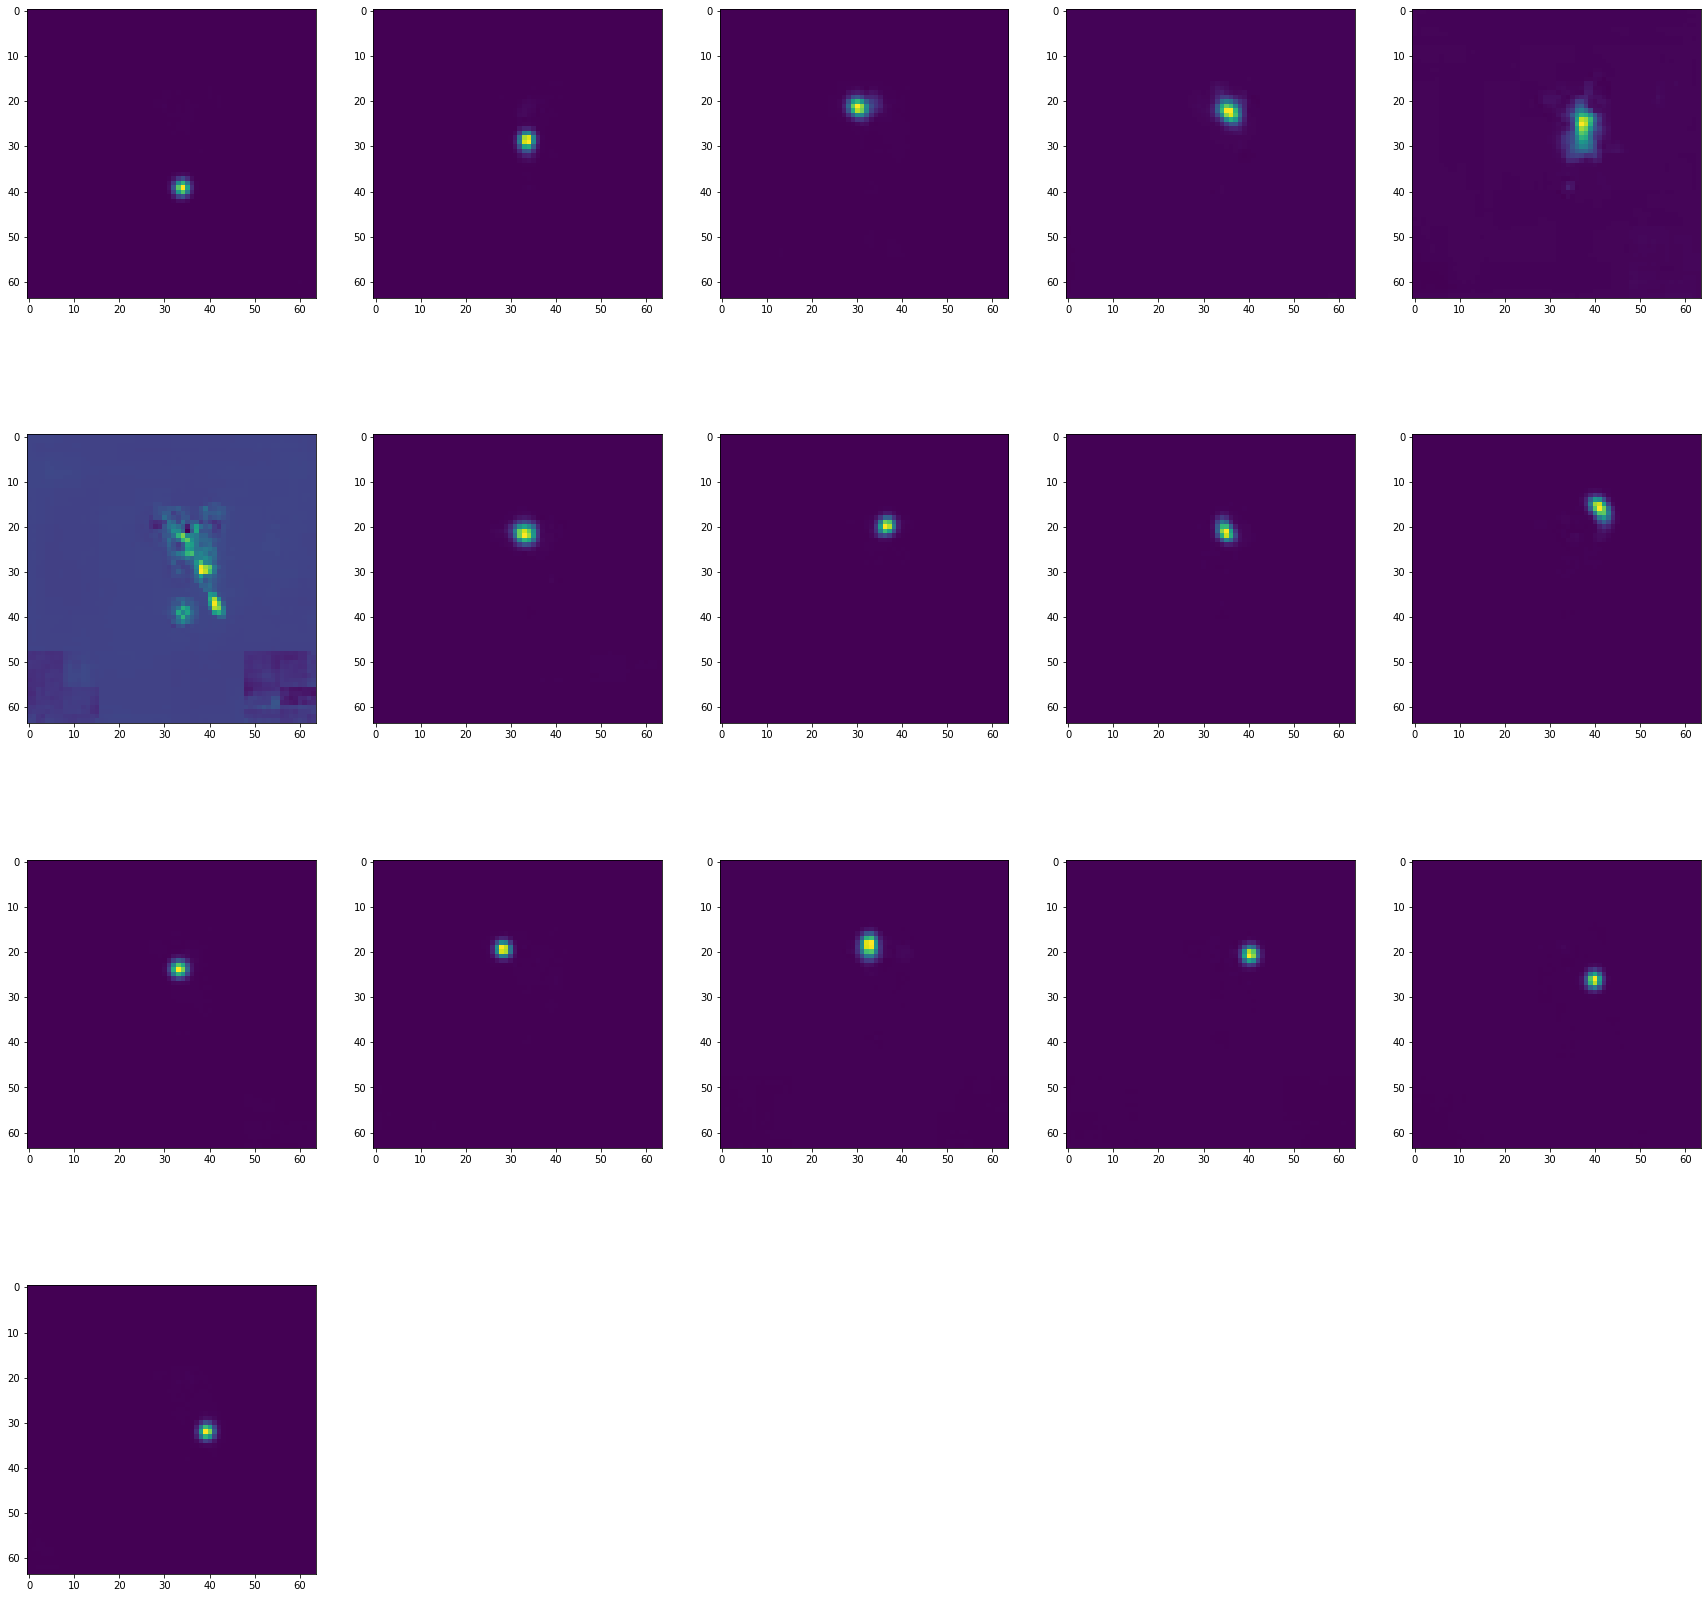

In [29]:
plt.figure(figsize=(30,30))
for n,i in enumerate(det[0]):
    plt.subplot(4,5,n+1)
    plt.imshow(i)

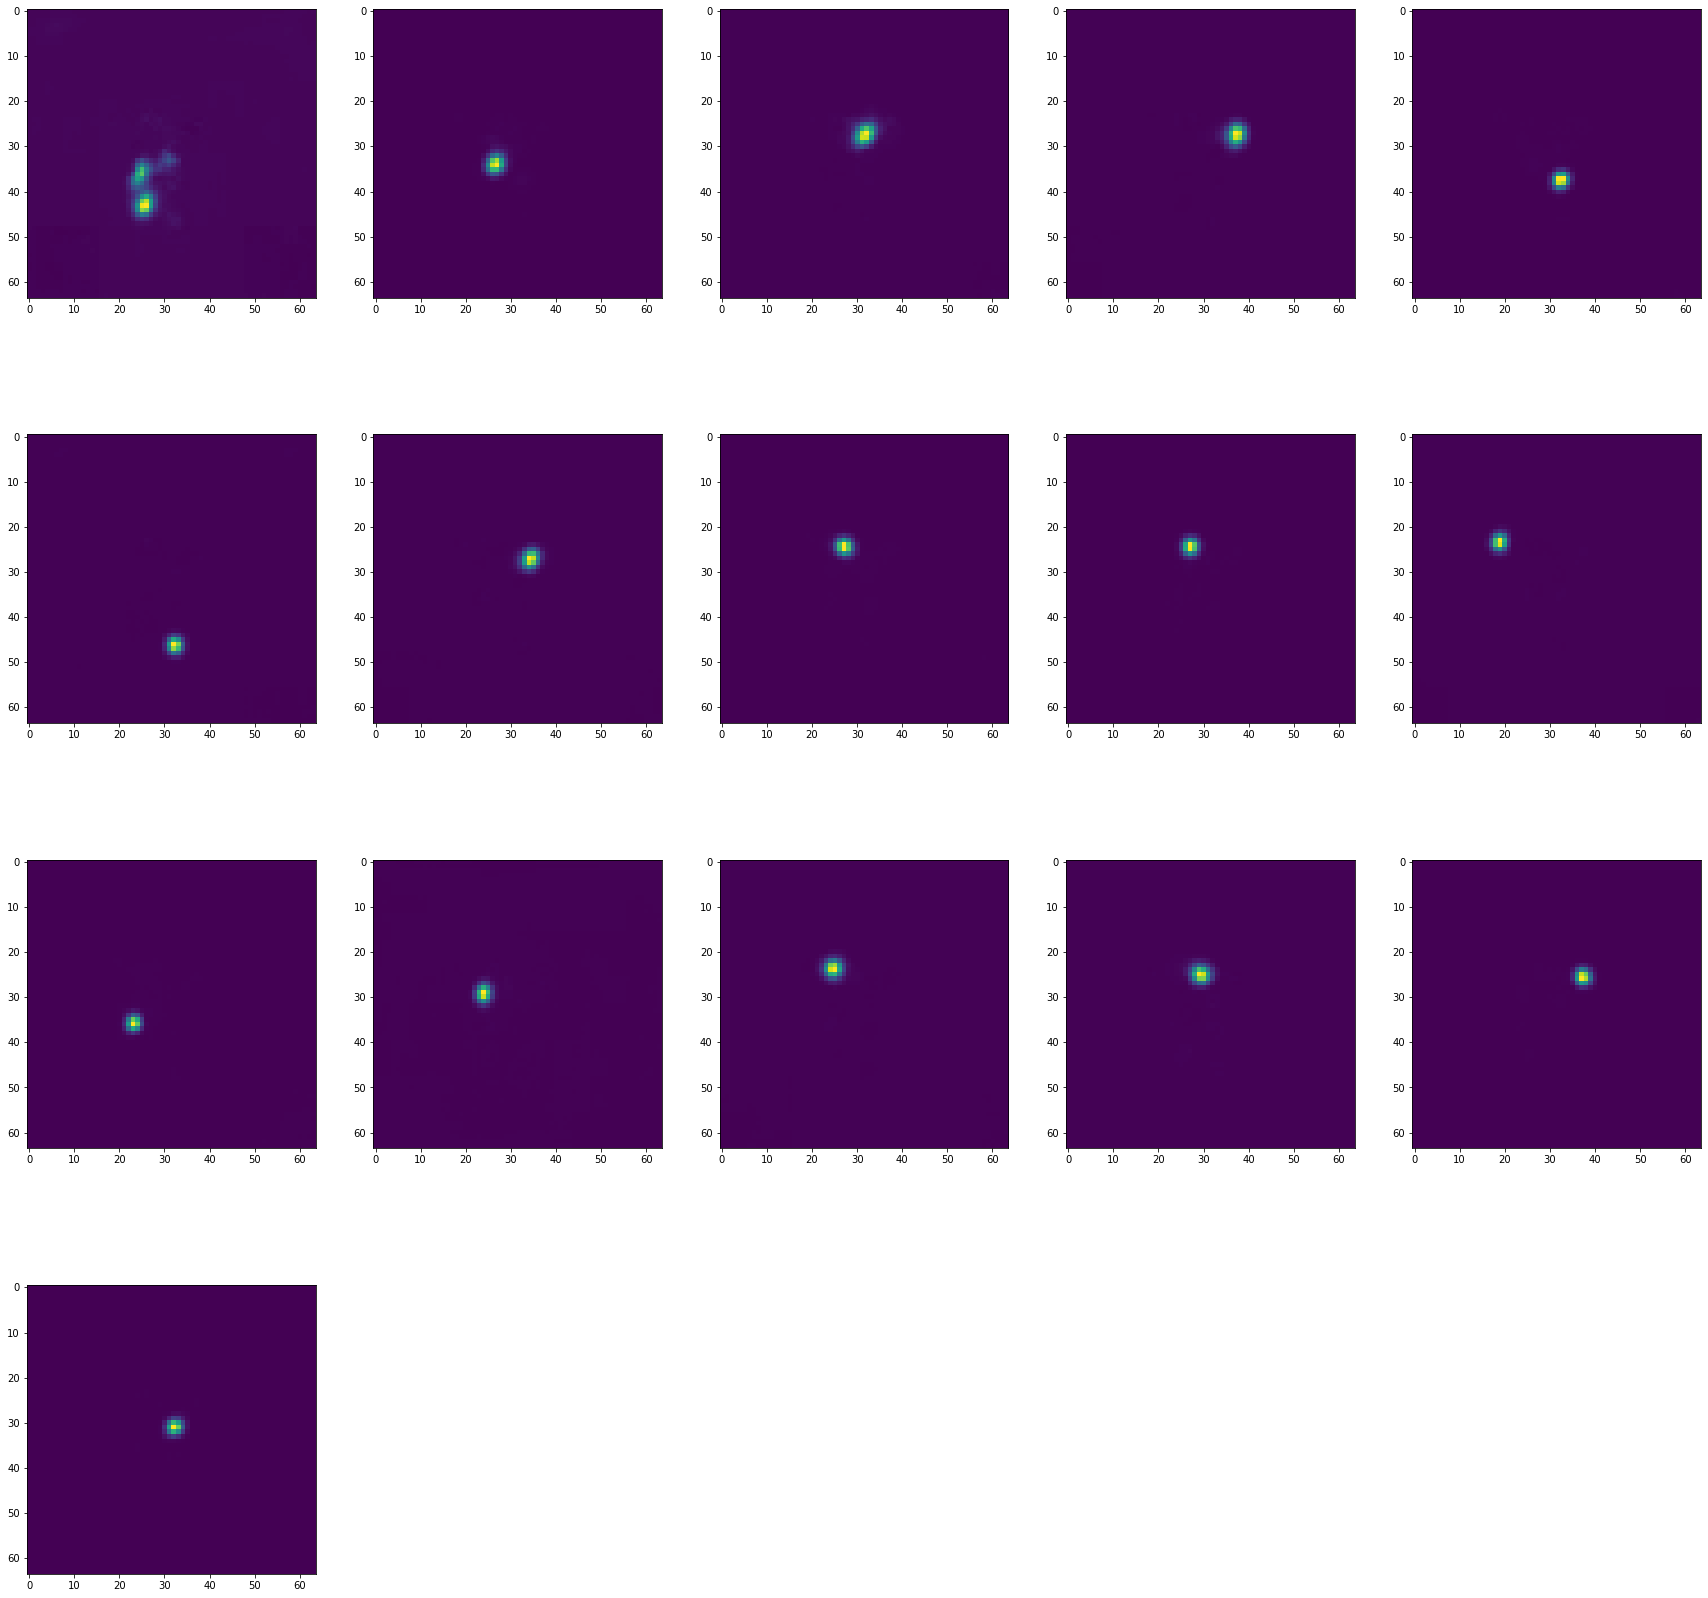

In [30]:
plt.figure(figsize=(30,30))
for n,i in enumerate(det[1]):
    plt.subplot(4,5,n+1)
    plt.imshow(i)

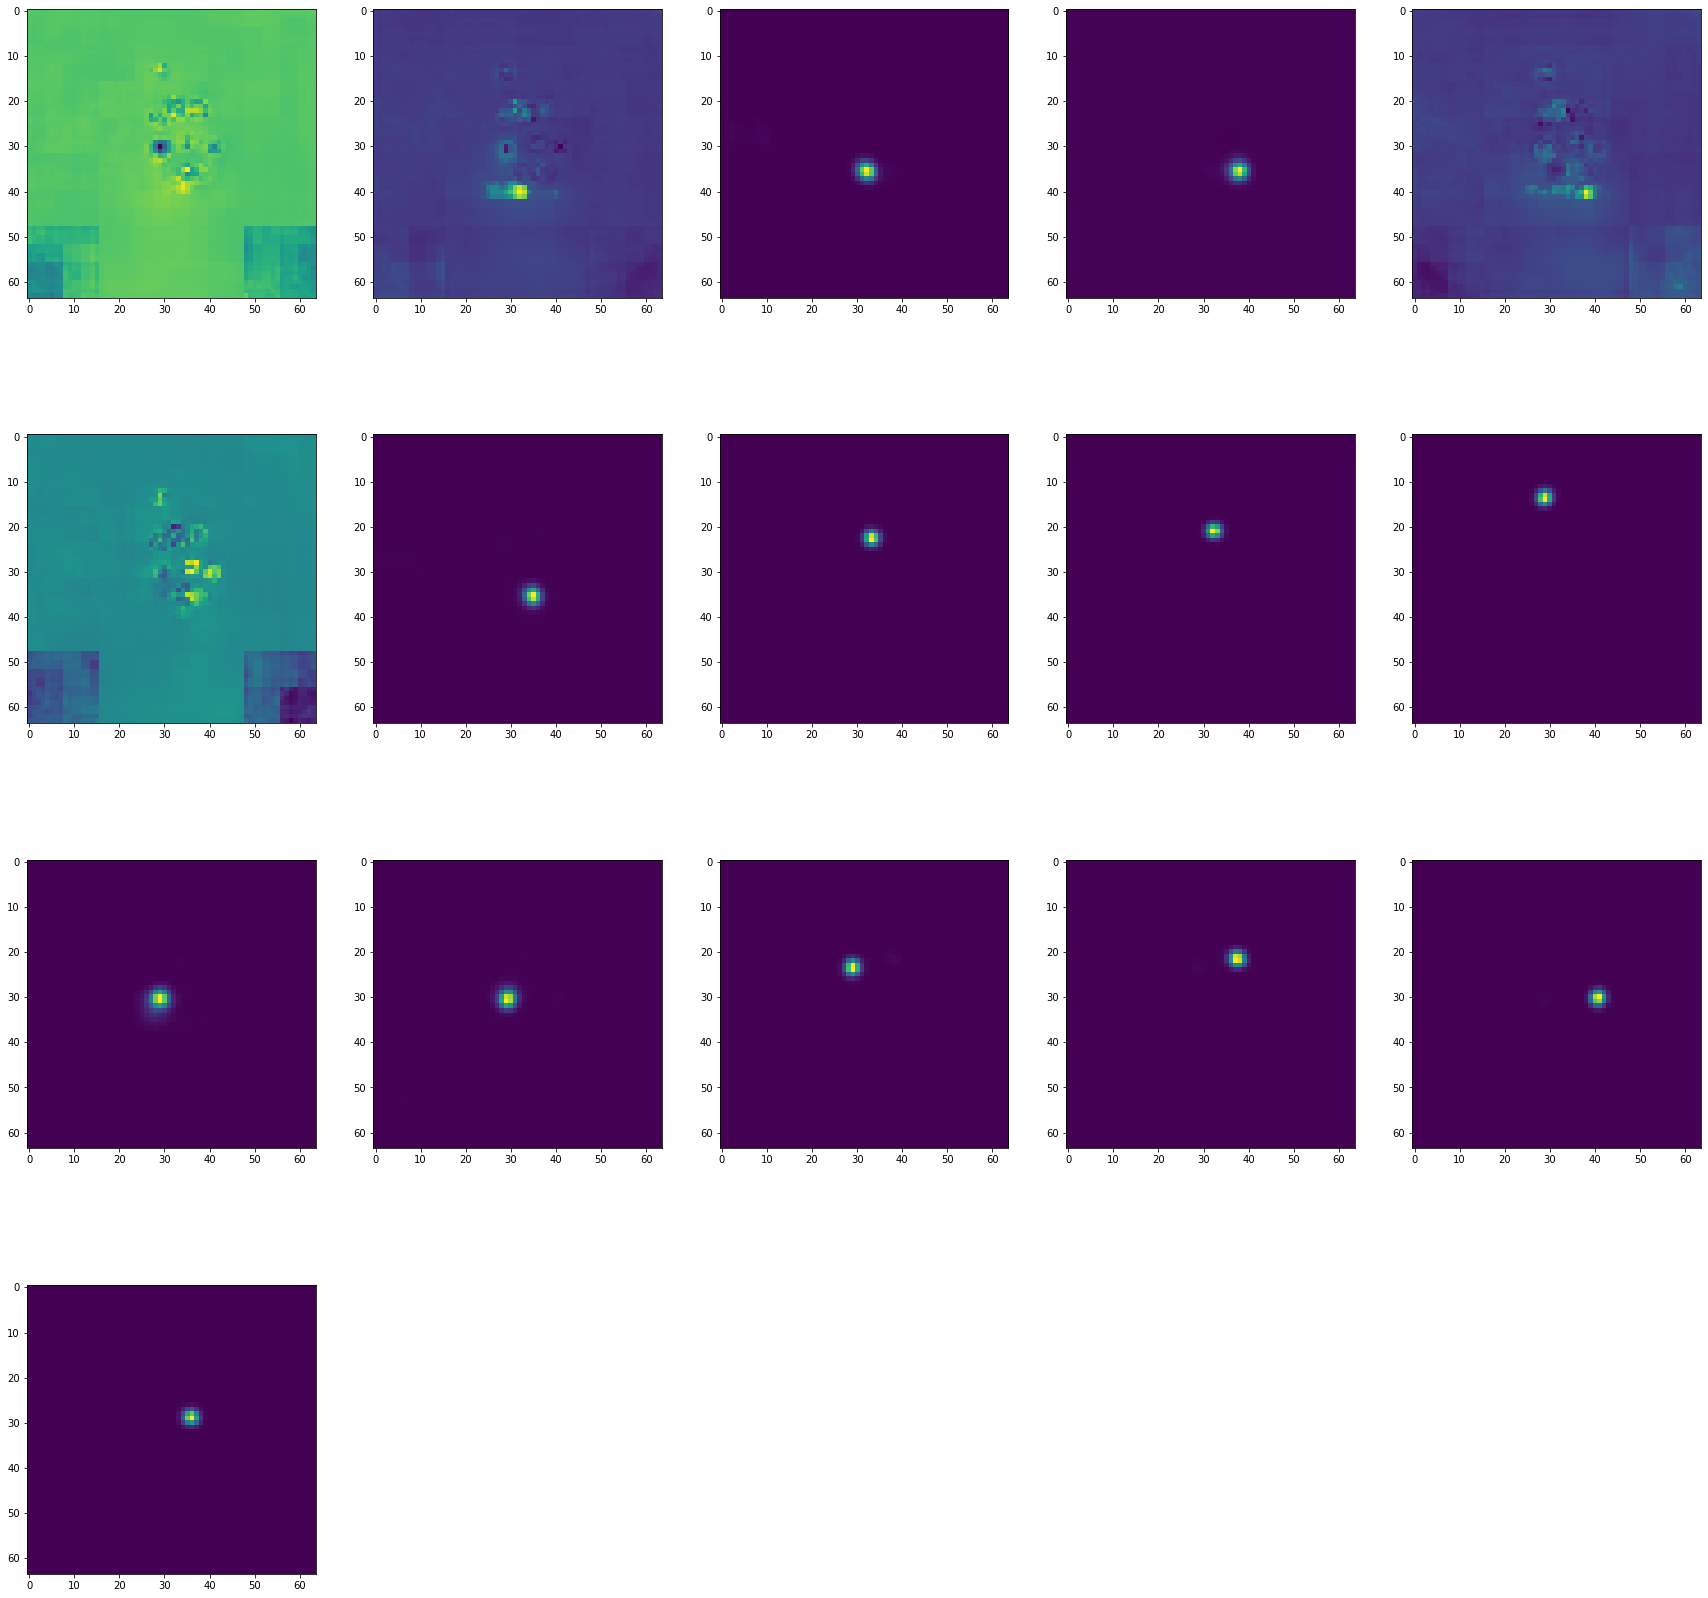

In [31]:
plt.figure(figsize=(30,30))
for n,i in enumerate(det[3]):
    plt.subplot(4,5,n+1)
    plt.imshow(i)